Reproduce the IJCAI15 Paper
======

**NOTE: Before running this notebook, please run script `src/ijcai15_setup.py` to setup data properly.**

# 1. Dataset [&#8648;](#toc)

The dataset used in [this paper](#https://sites.google.com/site/limkwanhui/publications/2015-IJCAI-personalTour.pdf?attredirects=0) can be downloaded [here](https://sites.google.com/site/limkwanhui/datacode/data-ijcai15.zip?attredirects=0), the [summary of this dataset](#https://sites.google.com/site/limkwanhui/datacode#ijcai15) is also available.
Unfortunately, one critical portion of information is missing, i.e. the geo-coordinates of each POI,
which is necessary for calculating the travel time from one POI to another.
However, it could be approximated by averaging (longitude, latitude) of 
all photos mapped to a specific POI by retriving coordinates of all photos in this dataset from the original [YFCC100M dataset](#http://www.referitgame.com/vicente/flickr100M/) using photoID.

Simple statistics of this dataset
<table>
<tr>
<td><b>City</b></td>
<td><b>#POIs</b></td>
<td><b>#Users</b></td>
<td><b>#POI_Visits</b></td>
<td><b>#Travel_Sequences</b></td></tr>
<tr><td>Toronto</td><td>29</td><td>1,395</td><td>39,419</td><td>6,057</td></tr>
<tr><td>Osaka</td><td>27</td><td>450</td><td>7,747</td><td>1,115</td></tr>
<tr><td>Glasgow</td><td>27</td><td>601</td><td>11,434</td><td>2,227</td></tr>
<tr><td>Edinburgh</td><td>28</td><td>1,454</td><td>33,944</td><td>5,028</td></tr>
</table>

*NOTE: the number of photos for each city described in [the paper](#https://sites.google.com/site/limkwanhui/publications/2015-IJCAI-personalTour.pdf?attredirects=0) is NOT available in this dataset*

## 1.1 Compute POI Coordinates

To compute the mean value of coordinates for all photos mapped to a POI, 
we need to search the coordinates for each photo from the 100 million records.
To accelerate the searching process, first extract the photo id, longitude and latitude columns from the whole dataset  
```
cut -d $'\t' -f1,11,12 yfcc100m_dataset >> dataset.yfcc
```  
and then import them to a database which was created by the following SQL scripts  
```
CREATE DATABASE yfcc100m;
CREATE TABLE yfcc100m.tdata(
    pv_id           BIGINT UNSIGNED NOT NULL UNIQUE PRIMARY KEY, /* Photo/video identifier */
    longitude       FLOAT,  /* Longitude */
    latitude        FLOAT   /* Latitude */
);
COMMIT;
```

Python scripts to import these data to DB looks like
```
import mysql.connector as db
def import_data(fname):
    dbconnection = db.connect(user='USERNAME', password='PASSWORD')
    cursor = dbconnection.cursor()
    with open(fname, 'r') as f:
        for line in f:
            items = line.split('\t')
            assert(len(items) == 3)
            pv_id = items[0].strip()
            lon   = items[1].strip()
            lat   = items[2].strip()
            if len(lon) == 0 or len(lat) == 0:
                continue
            sqlstr = 'INSERT INTO yfcc100m.tdata VALUES (' + pv_id + ', ' + lon + ', ' + lat + ')' 
            try:
                cursor.execute(sqlstr)
            except db.Error as error:
                print('ERROR: {}'.format(error))
    dbconnection.commit()
    dbconnection.close()
```

Python scripts to search coordinates for photos looks like
```
import mysql.connector as db
def search_coords(fin, fout):
    dbconnection = db.connect(user='USERNAME', password='PASSWORD', database='yfcc100m')
    cursor = dbconnection.cursor()
    with open(fout, 'w') as fo:
        with open(fin, 'r') as fi:
            for line in fi:
                items = line.split(';')
                assert(len(items) == 7)
                photoID = items[0].strip()
                sqlstr = 'SELECT longitude, latitude FROM tdata WHERE pv_id = ' + photoID
                cursor.execute(sqlstr)
                for longitude, latitude in cursor:
                    fo.write(photoID + ';' + str(longitude) + ';' + str(latitude) + '\n')
    dbconnection.commit()
    dbconnection.close()
```

The above retrived results are available and will be downloaded automatically by executing scripts `src/ijcai15_setup.py`.

# 2. Trajectory Recommendation Problem

## 2.1 Definitions

For user $u$ and POI $p$, define

* **Travel History**: 
\begin{equation*}
S_u = \{(p_1, t_{p_1}^a, t_{p_1}^d), \dots, (p_n, t_{p_n}^a, t_{p_n}^d)\}
\end{equation*}
where $t_{p_i}^a$ is the arrival time and $t_{p_i}^d$ the departure time of user $u$ at POI $p_i$

* **Travel Sequences**: split $S_u$ if
\begin{equation*}
|t_{p_i}^d - t_{p_{i+1}}^a| > \tau ~(\text{e.g.}~ \tau = 8 ~\text{hours})
\end{equation*}

* **POI Popularity**:
\begin{equation*}
Pop(p) = \sum_{u \in U} \sum_{p_i \in S_u} \delta(p_i == p)
\end{equation*}

* **Average POI Visit Duration**: 
\begin{equation*}
\bar{V}(p) = \frac{1}{N} \sum_{u \in U} \sum_{p_i \in S_u} (t_{p_i}^d - t_{p_i}^a) \delta(p_i == p)
\end{equation*}
where $N$ is \#visits of POI $p$ by all users
      
Define the interest of user $u$ in POI category $c$ as

* **Time based User Interest**:
\begin{equation*}
Int^{Time}(u, c) = \sum_{p_i \in S_u} \frac{(t_{p_i}^d - t_{p_i}^a)}{\bar{V}(p_i)} \delta(Cat_{p_i} == c)
\end{equation*}
where $Cat_{p_i}$ is the category of POI $p_i$  
we also tried this one
\begin{equation*}
Int^{Time}(u, c) = \frac{1}{n} \sum_{p_i \in S_u} \frac{(t_{p_i}^d - t_{p_i}^a)}{\bar{V}(p_i)} \delta(Cat_{p_i} == c)
\end{equation*}
where $n$ is the number of visit of category $c$ by user $u$ (i.e. the frequency base user interest defined below),
switch between the two definitions [here](#switch).


* **Frequency based User Interest**:
\begin{equation*}
Int^{Freq}(u, c) = \sum_{p_i \in S_u} \delta(Cat_{p_i} == c)
\end{equation*}

## 2.2 Problem Formulation

The paper formulates the itinerary recommendation problem as an Integer Linear Programming(ILP) as follows.

Given a set of POIs, time budget $B$, the starting/destination POI $p_1$/$p_N$,
recommend a trajectory $(p_1,\dots,p_N)$ to user $u$ that
\begin{equation*}
    \text{Maximize} \sum_{i=2}^{N-1} \sum_{j=2}^{N} x_{i,j} \left(\eta Int(u, Cat_{p_i}) + (1-\eta) Pop(p_i)\right)
\end{equation*}
Subject to
\begin{align*}
    %x_{i,j} \in \{0, 1\}, & \forall i,j = 1,\dots,N \\
    \sum_{j=2}^N x_{1,j} &= \sum_{i=1}^{N-1} x_{i,N} = 1 \\ %\text{(starts/ends at $p_1$/$p_N$)} \\
    \sum_{i=1}^{N-1} x_{i,k} &= \sum_{j=2}^{N} x_{k,j} \le 1, \forall k = 2,\dots,N-1 \\ %\text{(connected, enters/leaves $p_k$ at most once)}
    %q_i \in \{2,\dots,N\}, & \forall i = 2,\dots,N \\
    q_i - q_j + 1 &\le (N-1)(1-x_{i,j}), \forall i,j = 2,\dots,N \\ %\text{sub-tour elimination} \\
    %\sum_{i=1}^{N-1} \sum_{j=2}^N x_{i,j} Cost(i,j) \le B %\text{(budget constraint)}
    %\sum_{i=1}^{N-1} \sum_{j=2}^N x_{i,j} \left(T^{Travel}(p_i, p_j) + Int(u, Cat_{p_j}) * \bar{V}(p_j) \right) & \le B
    \sum_{i=1}^{N-1} \sum_{j=2}^N x_{i,j} & \left(Time(p_i, p_j) + Int(u, Cat_{p_j}) * \bar{V}(p_j) \right) \le B
\end{align*}

We use a Python library called [PuLP](https://github.com/coin-or/pulp) from the [COIN-OR](http://www.coin-or.org/) project to model the integer programs.
PuLP enables many LP solvers such as [GLPK](http://www.gnu.org/software/glpk/), [CBC](https://projects.coin-or.org/Cbc), [CPLEX](http://www.ibm.com/software/commerce/optimization/cplex-optimizer/) and [Gurobi](http://www.gurobi.com) to be called to solve the model.
Its comprehensive documentation is available [here](https://pythonhosted.org/PuLP/index.html).

# 3. Prepare Data

## 3.1 Load Trajectory Data

In [1]:
%matplotlib inline

import os
import re
import sys
import math
import pulp
import random
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
speed = 4 # 4km/h
random.seed(123456789)

In [3]:
data_dir = 'data/data-ijcai15'
#fvisit = os.path.join(data_dir, 'userVisits-Osak.csv')
#fcoord = os.path.join(data_dir, 'photoCoords-Osak.csv')
#fvisit = os.path.join(data_dir, 'userVisits-Glas.csv')
#fcoord = os.path.join(data_dir, 'photoCoords-Glas.csv')
#fvisit = os.path.join(data_dir, 'userVisits-Edin.csv')
#fcoord = os.path.join(data_dir, 'photoCoords-Edin.csv')
fvisit = os.path.join(data_dir, 'userVisits-Toro.csv')
fcoord = os.path.join(data_dir, 'photoCoords-Toro.csv')

In [4]:
suffix = fvisit.split('-')[-1].split('.')[0]
frecseq = os.path.join(data_dir, 'reccommendSeq-' + suffix + '.pkl')

In [5]:
visits = pd.read_csv(fvisit, sep=';')
visits.head()

,photoID,userID,dateTaken,poiID,poiTheme,poiFreq,seqID
0,7941504100,10007579@N00,1346844688,30,Structure,1538,1
1,4886005532,10012675@N05,1142731848,6,Cultural,986,2
2,4886006468,10012675@N05,1142732248,6,Cultural,986,2
3,4885404441,10012675@N05,1142732373,6,Cultural,986,2
4,4886008334,10012675@N05,1142732445,6,Cultural,986,2


In [6]:
coords = pd.read_csv(fcoord, sep=';')
coords.head()

,photoID,photoLon,photoLat
0,7941504100,-79.380844,43.645641
1,4886005532,-79.391525,43.654335
2,4886006468,-79.391525,43.654335
3,4885404441,-79.391525,43.654335
4,4886008334,-79.391525,43.654335


In [7]:
# merge data frames according to column 'photoID'
assert(visits.shape[0] == coords.shape[0])
traj = pd.merge(visits, coords, on='photoID')
traj.head()

,photoID,userID,dateTaken,poiID,poiTheme,poiFreq,seqID,photoLon,photoLat
0,7941504100,10007579@N00,1346844688,30,Structure,1538,1,-79.380844,43.645641
1,4886005532,10012675@N05,1142731848,6,Cultural,986,2,-79.391525,43.654335
2,4886006468,10012675@N05,1142732248,6,Cultural,986,2,-79.391525,43.654335
3,4885404441,10012675@N05,1142732373,6,Cultural,986,2,-79.391525,43.654335
4,4886008334,10012675@N05,1142732445,6,Cultural,986,2,-79.391525,43.654335


In [8]:
pd.DataFrame([traj[['photoLon', 'photoLat']].min(), traj[['photoLon', 'photoLat']].max(), \
             traj[['photoLon', 'photoLat']].max() - traj[['photoLon', 'photoLat']].min()], \
             index = ['min', 'max', 'range'])

,photoLon,photoLat
min,-79.465088,43.618523
max,-79.180336,43.822018
range,0.284752,0.203495


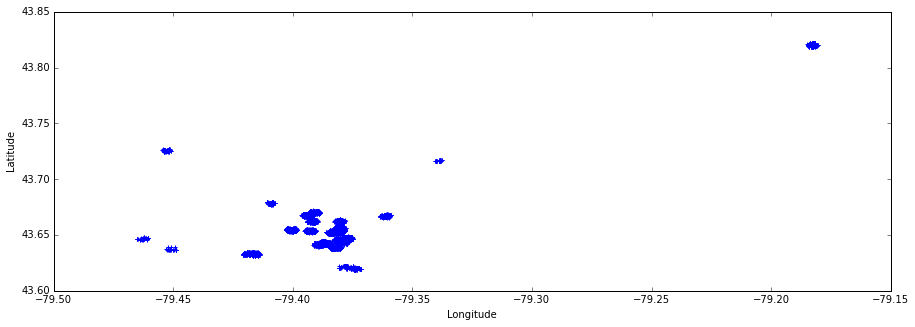

In [9]:
plt.figure(figsize=[15, 5])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.scatter(traj['photoLon'], traj['photoLat'], marker='+')

In [10]:
num_photo = traj['photoID'].unique().shape[0]
num_user = traj['userID'].unique().shape[0]
num_seq = traj['seqID'].unique().shape[0]
num_poi = traj['poiID'].unique().shape[0]
pd.DataFrame([num_photo, num_user, num_seq, num_poi, num_photo/num_user, num_seq/num_user], \
             index = ['#photo', '#user', '#seq', '#poi', '#photo/user', '#seq/user'], columns=[str(suffix)])

,Toro
#photo,39419.000000
#user,1395.000000
#seq,6057.000000
#poi,29.000000
#photo/user,28.257348
#seq/user,4.341935


<a id='sec3.2'></a>

## 3.2 Compute POI Info

Compute POI (Longitude, Latitude) as the average coordinates of the assigned photos.

In [11]:
poi_coords = traj[['poiID', 'photoLon', 'photoLat']].groupby('poiID').agg(np.mean)
poi_coords.reset_index(inplace=True)
poi_coords.rename(columns={'photoLon':'poiLon', 'photoLat':'poiLat'}, inplace=True)
poi_coords.head()

,poiID,poiLon,poiLat
0,1,-79.379243,43.643183
1,2,-79.418634,43.632772
2,3,-79.380045,43.662175
3,4,-79.389290,43.641297
4,6,-79.392396,43.653662


Extract POI category and visiting frequency.

In [12]:
poi_catfreq = traj[['poiID', 'poiTheme', 'poiFreq']].groupby('poiID').first()
poi_catfreq.reset_index(inplace=True)
poi_catfreq.head()

,poiID,poiTheme,poiFreq
0,1,Sport,3506
1,2,Sport,609
2,3,Sport,688
3,4,Sport,3056
4,6,Cultural,986


In [13]:
poi_all = pd.merge(poi_catfreq, poi_coords, on='poiID')
poi_all.set_index('poiID', inplace=True)
poi_all.head()

,poiTheme,poiFreq,poiLon,poiLat
poiID,,,,
1,Sport,3506,-79.379243,43.643183
2,Sport,609,-79.418634,43.632772
3,Sport,688,-79.380045,43.662175
4,Sport,3056,-79.389290,43.641297
6,Cultural,986,-79.392396,43.653662


## 3.3 Construct Travelling Sequences

In [14]:
seq_all = traj[['userID', 'seqID', 'poiID', 'dateTaken']].copy()\
          .groupby(['userID', 'seqID', 'poiID']).agg([np.min, np.max])
seq_all.head()

dateTaken            
                                amin        amax
userID       seqID poiID                        
10007579@N00 1     30     1346844688  1346844688
10012675@N05 2     6      1142731848  1142732445
             3     6      1142916492  1142916492
             4     13     1319327174  1319332848
10014440@N06 5     24     1196128621  1196128878

In [15]:
seq_all.columns = seq_all.columns.droplevel()
seq_all.head()

amin        amax
userID       seqID poiID                        
10007579@N00 1     30     1346844688  1346844688
10012675@N05 2     6      1142731848  1142732445
             3     6      1142916492  1142916492
             4     13     1319327174  1319332848
10014440@N06 5     24     1196128621  1196128878

In [16]:
seq_all.reset_index(inplace=True)
seq_all.head()

,userID,seqID,poiID,amin,amax
0,10007579@N00,1,30,1346844688,1346844688
1,10012675@N05,2,6,1142731848,1142732445
2,10012675@N05,3,6,1142916492,1142916492
3,10012675@N05,4,13,1319327174,1319332848
4,10014440@N06,5,24,1196128621,1196128878


In [17]:
seq_all.rename(columns={'amin':'arrivalTime', 'amax':'departureTime'}, inplace=True)
seq_all['poiDuration(sec)'] = seq_all['departureTime'] - seq_all['arrivalTime']
seq_all.head()

,userID,seqID,poiID,arrivalTime,departureTime,poiDuration(sec)
0,10007579@N00,1,30,1346844688,1346844688,0
1,10012675@N05,2,6,1142731848,1142732445,597
2,10012675@N05,3,6,1142916492,1142916492,0
3,10012675@N05,4,13,1319327174,1319332848,5674
4,10014440@N06,5,24,1196128621,1196128878,257


In [18]:
#tseq = seq_all[['poiID', 'poiDuration(sec)']].copy().groupby('poiID').agg(np.mean)
#tseq

In [19]:
seq_user = seq_all[['seqID', 'userID']].copy()
seq_user = seq_user.groupby('seqID').first()
seq_user.head()

,userID
seqID,
1,10007579@N00
2,10012675@N05
3,10012675@N05
4,10012675@N05
5,10014440@N06


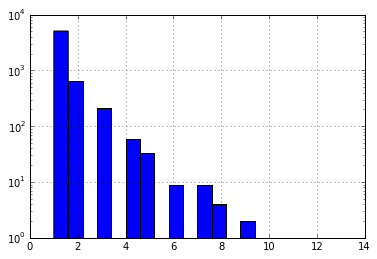

In [20]:
seq_len = seq_all[['userID', 'seqID', 'poiID']].copy()
seq_len = seq_len.groupby(['userID', 'seqID']).agg(np.size)
seq_len.reset_index(inplace=True)
seq_len.rename(columns={'poiID':'seqLen'}, inplace=True)
#seq_len.head()
ax = seq_len['seqLen'].hist(bins=20)
ax.set_yscale('log')

## 3.4 Transition Matrix

### 3.4.1 Transition Matrix for Time at POI

In [21]:
users = seq_all['userID'].unique()
transmat_time = pd.DataFrame(np.zeros((len(users), poi_all.index.shape[0]), dtype=np.float64), \
                             index=users, columns=poi_all.index)

In [22]:
poi_time = seq_all[['userID', 'poiID', 'poiDuration(sec)']].copy().groupby(['userID', 'poiID']).agg(np.sum)
poi_time.head()

poiDuration(sec)
userID       poiID                  
10007579@N00 30                    0
10012675@N05 6                   597
             13                 5674
10014440@N06 4                     0
             17                31482

In [23]:
for idx in poi_time.index:
    transmat_time.loc[idx[0], idx[1]] += poi_time.loc[idx].iloc[0]
print(transmat_time.shape)
transmat_time.head()

(1395, 29)


poiID,1,2,3,4,6,7,8,9,10,11,...,21,22,23,24,25,26,27,28,29,30
10007579@N00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10012675@N05,0,0,0,0,597,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10014440@N06,0,0,0,0,0,0,0,0,0,0,...,0,0,3674,2287,7991,0,0,0,0,0
10031363@N00,0,0,0,0,0,84,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10116041@N02,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
# add 1 (sec) to each cell as a smooth factor
log10_transmat_time = np.log10(transmat_time.copy() + 1)
print(log10_transmat_time.shape)
log10_transmat_time.head()

(1395, 29)


poiID,1,2,3,4,6,7,8,9,10,11,...,21,22,23,24,25,26,27,28,29,30
10007579@N00,0,0,0,0,0.000000,0.000000,0,0,0,0,...,0,0,0.000000,0.000000,0.000000,0,0,0,0,0
10012675@N05,0,0,0,0,2.776701,0.000000,0,0,0,0,...,0,0,0.000000,0.000000,0.000000,0,0,0,0,0
10014440@N06,0,0,0,0,0.000000,0.000000,0,0,0,0,...,0,0,3.565257,3.359456,3.902655,0,0,0,0,0
10031363@N00,0,0,0,0,0.000000,1.929419,0,0,0,0,...,0,0,0.000000,0.000000,0.000000,0,0,0,0,0
10116041@N02,0,0,0,0,0.000000,0.000000,0,0,0,0,...,0,0,0.000000,0.000000,0.000000,0,0,0,0,0


### 3.4.2 Transition Matrix for POI Category

In [25]:
poi_cats = traj['poiTheme'].unique().tolist()
poi_cats.sort()
poi_cats

['Amusement', 'Beach', 'Cultural', 'Shopping', 'Sport', 'Structure']

In [26]:
ncats = len(poi_cats)
transmat_cat = pd.DataFrame(data=np.zeros((ncats, ncats), dtype=np.float64), index=poi_cats, columns=poi_cats)

In [29]:
for seqid in seq_all['seqID'].unique().tolist():
    seqi = seq_all[seq_all['seqID'] == seqid].copy()
    seqi.sort(columns=['arrivalTime'], ascending=True, inplace=True)
    for j in range(len(seqi.index)-1):
        idx1 = seqi.index[j]
        idx2 = seqi.index[j+1]
        poi1 = seqi.loc[idx1, 'poiID']
        poi2 = seqi.loc[idx2, 'poiID']
        cat1 = poi_all.loc[poi1, 'poiTheme']
        cat2 = poi_all.loc[poi2, 'poiTheme']
        transmat_cat.loc[cat1, cat2] += 1
transmat_cat

,Amusement,Beach,Cultural,Shopping,Sport,Structure
Amusement,28,40,102,34,70,32
Beach,36,86,122,184,38,212
Cultural,92,140,80,144,44,188
Shopping,32,202,116,32,38,142
Sport,84,46,42,26,16,42
Structure,52,182,162,118,48,48


Normalise each row to get an estimate of transition probabilities (MLE).

In [30]:
for r in transmat_cat.index:
    rowsum = transmat_cat.ix[r].sum()
    if rowsum == 0: continue  # deal with lack of data
    transmat_cat.loc[r] /= rowsum
transmat_cat

,Amusement,Beach,Cultural,Shopping,Sport,Structure
Amusement,0.091503,0.130719,0.333333,0.111111,0.228758,0.104575
Beach,0.053097,0.126844,0.179941,0.271386,0.056047,0.312684
Cultural,0.133721,0.203488,0.116279,0.209302,0.063953,0.273256
Shopping,0.056940,0.359431,0.206406,0.056940,0.067616,0.252669
Sport,0.328125,0.179688,0.164062,0.101562,0.062500,0.164062
Structure,0.085246,0.298361,0.265574,0.193443,0.078689,0.078689


Compute the log of transition probabilities with smooth factor $\epsilon=10^{-12}$.

In [31]:
log10_transmat_cat = np.log10(transmat_cat.copy() + 1e-12)
log10_transmat_cat

,Amusement,Beach,Cultural,Shopping,Sport,Structure
Amusement,-1.038563,-0.883661,-0.477121,-0.954243,-0.640623,-0.980571
Beach,-1.274927,-0.896731,-0.744870,-0.566412,-1.251446,-0.504894
Cultural,-0.873801,-0.691460,-0.934498,-0.679226,-1.194136,-0.563431
Shopping,-1.244586,-0.444385,-0.685278,-1.244586,-1.169953,-0.597448
Sport,-0.483961,-0.745482,-0.784991,-0.993267,-1.204120,-0.784991
Structure,-1.069326,-0.525258,-0.575815,-0.713448,-1.104089,-1.104089


# 4. Trajectory Recommendation -- Approach I

A different leave-one-out cross-validation approach:
  - For each user, choose one trajectory (with length >= 3) uniformly at random from all of his/her trajectories 
    as the validation trajectory
  - Use all other trajectories (of all users) to 'train' (i.e. compute metrics for the ILP formulation)

## 4.1 Choose Cross Validation Sequences

In [32]:
cv_seqs = seq_all[['userID', 'seqID', 'poiID']].copy().groupby(['userID', 'seqID']).agg(np.size)
cv_seqs.rename(columns={'poiID':'seqLen'}, inplace=True)
cv_seqs = cv_seqs[cv_seqs['seqLen'] > 2]
cv_seqs.reset_index(inplace=True)
print(cv_seqs.shape)
cv_seqs.head()

(335, 3)


,userID,seqID,seqLen
0,10502709@N05,58,3
1,10502709@N05,67,3
2,10502709@N05,71,4
3,10627620@N06,99,3
4,10627620@N06,100,3


In [33]:
cv_seq_set = []

In [34]:
# choose one sequence for each user in cv_seqs uniformly at random
for user in cv_seqs['userID'].unique():
    seqlist = cv_seqs[cv_seqs['userID'] == user]['seqID'].tolist()
    seqid = random.choice(seqlist)
    cv_seq_set.append(seqid)

In [35]:
len(cv_seq_set)

196

## 4.2 Recommendation by Solving ILPs

In [37]:
def calc_poi_info(seqid_set, seq_all, poi_all):
    poi_info = seq_all[seq_all['seqID'].isin(seqid_set)][['poiID', 'poiDuration(sec)']].copy()
    poi_info = poi_info.groupby('poiID').agg([np.mean, np.size])
    poi_info.columns = poi_info.columns.droplevel()
    poi_info.reset_index(inplace=True)
    poi_info.rename(columns={'mean':'avgDuration(sec)', 'size':'popularity'}, inplace=True)
    poi_info.set_index('poiID', inplace=True)
    poi_info['poiTheme'] = poi_all.loc[poi_info.index, 'poiTheme']
    poi_info['poiLon'] = poi_all.loc[poi_info.index, 'poiLon']
    poi_info['poiLat'] = poi_all.loc[poi_info.index, 'poiLat']
    return poi_info.copy()

In [38]:
def calc_user_interest(seqid_set, seq_all, poi_all, poi_info):
    user_interest = seq_all[seq_all['seqID'].isin(seqid_set)][['userID', 'poiID', 'poiDuration(sec)']].copy()
    user_interest['timeRatio'] = [poi_info.loc[x, 'avgDuration(sec)'] for x in user_interest['poiID']]
    user_interest['timeRatio'] = user_interest['poiDuration(sec)'] / user_interest['timeRatio']
    user_interest['poiTheme'] = [poi_all.loc[x, 'poiTheme'] for x in user_interest['poiID']]
    user_interest.drop(['poiID', 'poiDuration(sec)'], axis=1, inplace=True)
    user_interest = user_interest.groupby(['userID', 'poiTheme']).agg([np.sum, np.size]) # the sum
    user_interest.columns = user_interest.columns.droplevel()
    user_interest.rename(columns={'sum':'timeBased', 'size':'freqBased'}, inplace=True)
    user_interest.reset_index(inplace=True)
    user_interest.set_index(['userID', 'poiTheme'], inplace=True)
    return user_interest.copy()

In [39]:
def calc_dist(longitude1, latitude1, longitude2, latitude2):
    """Calculate the distance (unit: km) between two places on earth"""
    # convert degrees to radians
    lon1 = math.radians(longitude1)
    lat1 = math.radians(latitude1)
    lon2 = math.radians(longitude2)
    lat2 = math.radians(latitude2)
    radius = 6371.009 # mean earth radius is 6371.009km, en.wikipedia.org/wiki/Earth_radius#Mean_radius
    # The haversine formula, en.wikipedia.org/wiki/Great-circle_distance
    dlon = math.fabs(lon1 - lon2)
    dlat = math.fabs(lat1 - lat2)
    return 2 * radius * math.asin(math.sqrt(\
               (math.sin(0.5*dlat))**2 + math.cos(lat1) * math.cos(lat2) * (math.sin(0.5*dlon))**2 ))

In [40]:
def calc_dist_mat(poi_info):
    poi_dist_mat = pd.DataFrame(data=np.zeros((poi_info.shape[0], poi_info.shape[0]), dtype=np.float64), \
                            index=poi_info.index, columns=poi_info.index)
    for i in range(poi_info.index.shape[0]):
        for j in range(i+1, poi_info.index.shape[0]):
            r = poi_info.index[i]
            c = poi_info.index[j]
            dist = calc_dist(poi_info.loc[r, 'poiLon'], poi_info.loc[r, 'poiLat'], \
                             poi_info.loc[c, 'poiLon'], poi_info.loc[c, 'poiLat'])
            assert(dist > 0.)
            poi_dist_mat.loc[r, c] = dist
            poi_dist_mat.loc[c, r] = dist
    return poi_dist_mat

In [41]:
def calc_seq_budget(user, seq, poi_info, poi_dist_mat, user_interest):
    """Calculate the travel budget for the given travelling sequence"""
    assert(len(seq) > 1)
    budget = 0. # travel budget
    for i in range(len(seq)-1):
        px = seq[i]
        py = seq[i+1]
        assert(px in poi_info.index)
        assert(py in poi_info.index)
        budget += 60 * 60 * poi_dist_mat.loc[px, py] / speed  # travel time (seconds)
        caty = poi_info.loc[py, 'poiTheme']
        avgtime = poi_info.loc[py, 'avgDuration(sec)']
        userint = 0
        if (user, caty) in user_interest.index: userint = user_interest.loc[user, caty] # for testing set
        budget += userint * avgtime  # expected visit duration
    return budget

In [42]:
def recommend_ILP(user, budget, startPoi, endPoi, poi_info, poi_dist_mat, eta, speed, user_interest):
    assert(0 <= eta <= 1); assert(budget > 0)
    p0 = str(startPoi); pN = str(endPoi); N = poi_info.index.shape[0]
    
    # REF: pythonhosted.org/PuLP/index.html
    pois = [str(p) for p in poi_info.index] # create a string list for each POI
    prob = pulp.LpProblem('TourRecommendation', pulp.LpMaximize) # create problem
    # visit_i_j = 1 means POI i and j are visited in sequence
    visit_vars = pulp.LpVariable.dicts('visit', (pois, pois), 0, 1, pulp.LpInteger) 
    # a dictionary contains all dummy variables
    dummy_vars = pulp.LpVariable.dicts('u', [x for x in pois if x != p0], 2, N, pulp.LpInteger)

    # add objective
    objlist = []
    for pi in [x for x in pois if x not in {p0, pN}]:
        for pj in [y for y in pois if y != p0]:
            cati = poi_info.loc[int(pi), 'poiTheme']
            userint = 0; poipop = 0
            if (user, cati) in user_interest.index: userint = user_interest.loc[user, cati]
            if int(pi) in poi_info.index: poipop = poi_info.loc[int(pi), 'popularity']
            objlist.append(visit_vars[pi][pj] * (eta * userint + (1.-eta) * poipop))
    prob += pulp.lpSum(objlist), 'Objective'
    
    # add constraints, each constraint should be in ONE line
    prob += pulp.lpSum([visit_vars[p0][pj] for pj in pois if pj != p0]) == 1, 'StartAtp0'
    prob += pulp.lpSum([visit_vars[pi][pN] for pi in pois if pi != pN]) == 1, 'EndAtpN'
    for pk in [x for x in pois if x not in {p0, pN}]:
        prob += pulp.lpSum([visit_vars[pi][pk] for pi in pois if pi != pN]) == \
                pulp.lpSum([visit_vars[pk][pj] for pj in pois if pj != p0]), 'Connected_' + pk
        prob += pulp.lpSum([visit_vars[pi][pk] for pi in pois if pi != pN]) <= 1, 'LeaveAtMostOnce_' + pk
        prob += pulp.lpSum([visit_vars[pk][pj] for pj in pois if pj != p0]) <= 1, 'EnterAtMostOnce_' + pk
    
    costlist = []
    for pi in [x for x in pois if x != pN]:
        for pj in [y for y in pois if y != p0]:
            catj = poi_info.loc[int(pj), 'poiTheme']
            traveltime = 60 * 60 * poi_dist_mat.loc[int(pi), int(pj)] / speed # seconds
            userint = 0; avgtime = 0
            if (user, catj) in user_interest.index: userint = user_interest.loc[user, catj]
            if int(pj) in poi_info.index: avgtime = poi_info.loc[int(pj), 'avgDuration(sec)']
            costlist.append(visit_vars[pi][pj] * (traveltime + userint * avgtime))
    prob += pulp.lpSum(costlist) <= budget, 'WithinBudget'
    
    for pi in [x for x in pois if x != p0]:
        for pj in [y for y in pois if y != p0]:
            prob += dummy_vars[pi] - dummy_vars[pj] + 1 <= (N - 1) * (1 - visit_vars[pi][pj]), \
                    'SubTourElimination_' + str(pi) + '_' + str(pj)

    # solve problem
    #prob.solve() # using PuLP's default solver
    #prob.solve(pulp.PULP_CBC_CMD(options=['-threads', '8', '-strategy', '1', '-maxIt', '2000000'])) # CBC
    #prob.solve(pulp.GLPK_CMD()) # GLPK
    gurobi_options = [('TimeLimit', '7200'), ('Threads', '18'), ('NodefileStart', '0.9'), ('Cuts', '2')]
    prob.solve(pulp.GUROBI_CMD(options=gurobi_options)) # GUROBI
    
    print('status:', pulp.LpStatus[prob.status]) # print the status of the solution
    #print('obj:', pulp.value(prob.objective)) # print the optimised objective function value
    #for v in prob.variables(): # print each variable with it's resolved optimum value
    #    print(v.name, '=', v.varValue)
    #    if v.varValue != 0: print(v.name, '=', v.varValue)

    visit_mat = pd.DataFrame(data=np.zeros((len(pois), len(pois)), dtype=np.float), index=pois, columns=pois)
    for pi in pois:
        for pj in pois: visit_mat.loc[pi, pj] = visit_vars[pi][pj].varValue

    # build the recommended trajectory
    recseq = [p0]
    while True:
        pi = recseq[-1]
        pj = visit_mat.loc[pi].idxmax()
        assert(round(visit_mat.loc[pi, pj]) == 1)
        recseq.append(pj); 
        #print(recseq); sys.stdout.flush()
        if pj == pN: return [int(x) for x in recseq]

In [43]:
cv_seq_dict = dict()
rec_seq_dict = dict()

In [46]:
for seqid in cv_seq_set:
    seqi = seq_all[seq_all['seqID'] == seqid].copy()
    seqi.sort(columns=['arrivalTime'], ascending=True, inplace=True)
    cv_seq_dict[seqid] = seqi['poiID'].tolist()

In [47]:
eta = 0.5
time_based = True

In [48]:
doCompute = True

In [49]:
if os.path.exists(frecseq):
    seq_dict = pickle.load(open(frecseq, 'rb'))
    if (np.array(sorted(cv_seq_dict.keys())) == np.array(sorted(seq_dict.keys()))).all():
        rec_seq_dict = seq_dict
        doCompute = False

In [50]:
if doCompute:
    n = 1
    print('#sequences', len(cv_seq_set))
    for seqid, seq in cv_seq_dict.items():
        train_set = [x for x in seq_all['seqID'].unique() if x != seqid]
        poi_info = calc_poi_info(train_set, seq_all, poi_all)
        user_interest = calc_user_interest(train_set, seq_all, poi_all, poi_info)
        poi_dist_mat = calc_dist_mat(poi_info)
        user = seq_user.loc[seqid].iloc[0]
        the_user_interest = None
        if time_based == True: the_user_interest = user_interest['timeBased'].copy()
        else: the_user_interest = user_interest['freqBased'].copy()
        budget = calc_seq_budget(user, seq, poi_info, poi_dist_mat, the_user_interest)
        print(n, 'sequence', seq, ', user', user, ', budget', budget); sys.stdout.flush()

        recseq = recommend_ILP(user, budget, seq[0], seq[-1], poi_info, poi_dist_mat, eta, speed, the_user_interest)
        rec_seq_dict[seqid] = recseq
        print('->', recseq, '\n'); sys.stdout.flush()
        n += 1
        
    pickle.dump(rec_seq_dict, open(frecseq, 'wb'))

## 4.3 Evaluation

Results from paper (Toronto data, time-based uesr interest, eta=0.5):  
 - Recall: 0.779&plusmn;0.10
 - Precision: 0.706&plusmn;0.013
 - F1-score: 0.732&plusmn;0.012

In [51]:
def calc_recall_precision_F1score(seq_act, seq_rec):
    assert(len(seq_act) > 0)
    assert(len(seq_rec) > 0)
    actset = set(seq_act)
    recset = set(seq_rec)
    intersect = actset & recset
    recall = len(intersect) / len(seq_act)
    precision = len(intersect) / len(seq_rec)
    F1score = 2. * precision * recall / (precision + recall)
    return recall, precision, F1score

In [52]:
recall = []
precision = []
F1score = []

In [53]:
for seqid in rec_seq_dict.keys():
    assert(seqid in cv_seq_dict)
    seq = cv_seq_dict[seqid]
    recseq = rec_seq_dict[seqid]
    r, p, F1 = calc_recall_precision_F1score(seq, recseq)
    recall.append(r)
    precision.append(p)
    F1score.append(F1)

In [54]:
print('Recall:', np.mean(recall), np.std(recall))
print('Precision:', np.mean(precision), np.std(precision))
print('F1-score:', np.mean(F1score), np.std(F1score))

Recall: 0.799609248461 0.159423808706
Precision: 0.588031802739 0.321897593535
F1-score: 0.647169986114 0.278463638008


# 5. Trajectory Recommendation -- Approach II

The paper stated *"We evaluate PERSTOUR and the baselines using leave-one-out cross-validation [Kohavi,1995] (i.e., when evaluating a specific travel sequence of a user, we use this user's other travel sequences for training our algorithms"*

While it's not clear if this means when evaluate a travel sequence for a user,
   - all other sequences of this user (except the one for validation) as well as all sequences of other users are used for training, (i.e. the approach in the section above) or
   - use leave-one-out for each user to construct a testing set (the approach in this section)

## 5.1 Choose Travelling Sequences for Training and Testing

Trajectories with length greater than `3` are used in the paper.

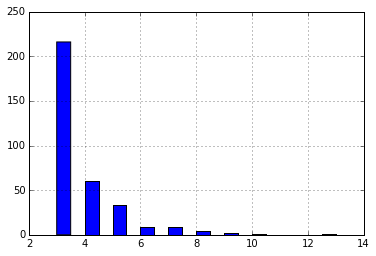

In [558]:
seq_ge3 = seq_len[seq_len['seqLen'] >= 3]
seq_ge3['seqLen'].hist(bins=20)

Split travelling sequences into training set and testing set using leave-one-out for each user.  
*For testing purpose, users with less than two travelling sequences are not considered in this experiment.*

In [559]:
train_set = []
test_set = []

In [560]:
user_seqs = seq_ge3[['userID', 'seqID']].groupby('userID')

In [561]:
for user, indices in user_seqs.groups.items():
    if len(indices) < 2: continue
    idx = random.choice(indices)
    test_set.append(seq_ge3.loc[idx, 'seqID'])
    train_set.extend([seq_ge3.loc[x, 'seqID'] for x in indices if x != idx])

#seq in trainset: 139
#seq in testset: 44


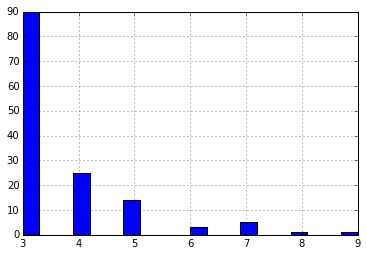

In [562]:
print('#seq in trainset:', len(train_set))
print('#seq in testset:', len(test_set))
seq_ge3[seq_ge3['seqID'].isin(train_set)]['seqLen'].hist(bins=20)
#data = np.array(seqs1['seqLen'])
#hist, bins = np.histogram(data, bins=3)
#print(hist)

#### Sanity check: the total number of travelling sequences used in training and testing

In [563]:
seq_exp = seq_ge3[['userID', 'seqID']].copy()
seq_exp = seq_exp.groupby('userID').agg(np.size)
seq_exp.reset_index(inplace=True)
seq_exp.rename(columns={'seqID':'#seq'}, inplace=True)
seq_exp = seq_exp[seq_exp['#seq'] > 1] # user with more than 1 sequences
print('total #seq for experiment:', seq_exp['#seq'].sum())
#seq_exp.head()

total #seq for experiment: 183


## 5.2 Compute POI popularity and user interest using training set

Compute average POI visit duration, POI popularity as defined at the [top of the notebook](#sec1.1).

In [564]:
poi_info = seq_all[seq_all['seqID'].isin(train_set)]
poi_info = poi_info[['poiID', 'poiDuration(sec)']].copy()

In [565]:
poi_info = poi_info.groupby('poiID').agg([np.mean, np.size])
poi_info.columns = poi_info.columns.droplevel()
poi_info.reset_index(inplace=True)
poi_info.rename(columns={'mean':'avgDuration(sec)', 'size':'popularity'}, inplace=True)
poi_info.set_index('poiID', inplace=True)
print('#poi:', poi_info.shape[0])
if poi_info.shape[0] < poi_all.shape[0]:
    extra_index = list(set(poi_all.index) - set(poi_info.index))
    extra_poi = pd.DataFrame(data=np.zeros((len(extra_index), 2), dtype=np.float64), \
                             index=extra_index, columns=['avgDuration(sec)', 'popularity'])
    poi_info = poi_info.append(extra_poi)
    print('#poi after extension:', poi_info.shape[0])
poi_info['poiTheme'] = poi_all.loc[poi_info.index, 'poiTheme']
poi_info['poiLon'] = poi_all.loc[poi_info.index, 'poiLon']
poi_info['poiLat'] = poi_all.loc[poi_info.index, 'poiLat']
poi_info.head()

#poi: 23
#poi after extension: 29


,avgDuration(sec),popularity,poiTheme,poiLon,poiLat
poiID,,,,,
1,5045.600000,10,Sport,-79.379243,43.643183
2,3957.833333,6,Sport,-79.418634,43.632772
3,1003.428571,14,Sport,-79.380045,43.662175
4,3126.444444,9,Sport,-79.389290,43.641297
6,1826.384615,13,Cultural,-79.392396,43.653662


Compute time/frequency based user interest as defined at the 
[top of the notebook](#sec1.1).

In [567]:
user_interest = seq_all[seq_all['seqID'].isin(train_set)]
user_interest = user_interest[['userID', 'poiID', 'poiDuration(sec)']].copy()

In [568]:
user_interest['timeRatio'] = [poi_info.loc[x, 'avgDuration(sec)'] for x in user_interest['poiID']]
#user_interest[user_interest['poiID'].isin({9, 10, 12, 18, 20, 26})]
#user_interest[user_interest['timeRatio'] < 1]
user_interest.head()

,userID,poiID,poiDuration(sec),timeRatio
71,10502709@N05,22,2164,2991.687500
72,10502709@N05,23,5133,2725.558824
73,10502709@N05,28,17388,2062.137931
77,10502709@N05,21,0,2595.469697
78,10502709@N05,22,0,2991.687500


In [569]:
user_interest['timeRatio'] = user_interest['poiDuration(sec)'] / user_interest['timeRatio']
user_interest.head()

,userID,poiID,poiDuration(sec),timeRatio
71,10502709@N05,22,2164,0.723338
72,10502709@N05,23,5133,1.883284
73,10502709@N05,28,17388,8.432026
77,10502709@N05,21,0,0.000000
78,10502709@N05,22,0,0.000000


In [570]:
user_interest['poiTheme'] = [poi_all.loc[x, 'poiTheme'] for x in user_interest['poiID']]
user_interest.drop(['poiID', 'poiDuration(sec)'], axis=1, inplace=True)

<a id='switch'></a>

**Sum defined in paper, but sum of (time ratio) * (avg duration) will become extremely large in some cases, which is unrealistic, switch between the two to have a look at the effects.**

In [571]:
#user_interest = user_interest.groupby(['userID', 'poiTheme']).agg([np.sum, np.size]) # the sum
user_interest = user_interest.groupby(['userID', 'poiTheme']).agg([np.mean, np.size]) # try the mean value

In [572]:
user_interest.columns = user_interest.columns.droplevel()
#user_interest.rename(columns={'sum':'timeBased', 'size':'freqBased'}, inplace=True)
user_interest.rename(columns={'mean':'timeBased', 'size':'freqBased'}, inplace=True)
user_interest.reset_index(inplace=True)
user_interest.set_index(['userID', 'poiTheme'], inplace=True)
user_interest.head()

timeBased  freqBased
userID       poiTheme                       
10502709@N05 Beach       0.241113          3
             Shopping    0.941642          2
             Structure   4.297239          2
10627620@N06 Beach       0.071663          1
             Shopping    0.067876          1

In [573]:
#user_interest.columns.shape[0]

## 5.3 Generate ILP

In [575]:
poi_dist_mat = pd.DataFrame(data=np.zeros((poi_info.shape[0], poi_info.shape[0]), dtype=np.float64), \
                            index=poi_info.index, columns=poi_info.index)
for i in range(poi_info.index.shape[0]):
    for j in range(i+1, poi_info.index.shape[0]):
        r = poi_info.index[i]
        c = poi_info.index[j]
        dist = calc_dist(poi_info.loc[r, 'poiLon'], poi_info.loc[r, 'poiLat'], \
                         poi_info.loc[c, 'poiLon'], poi_info.loc[c, 'poiLat'])
        assert(dist > 0.)
        poi_dist_mat.loc[r, c] = dist
        poi_dist_mat.loc[c, r] = dist

In [577]:
def generate_ILP(lpFilename, user, budget, startPoi, endPoi, poi_info, poi_dist_mat, eta, speed, user_interest):
    """Recommend a trajectory given an existing travel sequence S_N, 
       the first/last POI and travel budget calculated based on S_N
    """
    assert(0 <= eta <= 1)
    assert(budget > 0)
    p0 = str(startPoi)
    pN = str(endPoi)
    N = poi_info.index.shape[0]
    
    # The MIP problem
    # REF: pythonhosted.org/PuLP/index.html
    # create a string list for each POI
    pois = [str(p) for p in poi_info.index]

    # create problem
    prob = pulp.LpProblem('TourRecommendation', pulp.LpMaximize)

    # visit_i_j = 1 means POI i and j are visited in sequence
    visit_vars = pulp.LpVariable.dicts('visit', (pois, pois), 0, 1, pulp.LpInteger)

    # a dictionary contains all dummy variables
    dummy_vars = pulp.LpVariable.dicts('u', [x for x in pois if x != p0], 2, N, pulp.LpInteger)

    # add objective
    objlist = []
    for pi in [x for x in pois if x not in {p0, pN}]:
        for pj in [y for y in pois if y != p0]:
            cati = poi_info.loc[int(pi), 'poiTheme']
            userint = 0
            if (user, cati) in user_interest.index: userint = user_interest.loc[user, cati]
            objlist.append(visit_vars[pi][pj] * (eta * userint + (1.-eta) * poi_info.loc[int(pi), 'popularity']))
    prob += pulp.lpSum(objlist), 'Objective'
    # add constraints
    # each constraint should be in ONE line
    prob += pulp.lpSum([visit_vars[p0][pj] for pj in pois if pj != p0]) == 1, 'StartAtp0' # starts at the first POI
    prob += pulp.lpSum([visit_vars[pi][pN] for pi in pois if pi != pN]) == 1, 'EndAtpN'   # ends at the last POI
    for pk in [x for x in pois if x not in {p0, pN}]:
        prob += pulp.lpSum([visit_vars[pi][pk] for pi in pois if pi != pN]) == \
                pulp.lpSum([visit_vars[pk][pj] for pj in pois if pj != p0]), \
                'Connected_' + pk                                                         # the itinerary is connected
        prob += pulp.lpSum([visit_vars[pi][pk] for pi in pois if pi != pN]) <= 1, \
                'LeaveAtMostOnce_' + pk                                                   # LEAVE POIk at most once
        prob += pulp.lpSum([visit_vars[pk][pj] for pj in pois if pj != p0]) <= 1, \
                'EnterAtMostOnce_' + pk                                                   # ENTER POIk at most once
    
    # travel cost within budget
    costlist = []
    for pi in [x for x in pois if x != pN]:
        for pj in [y for y in pois if y != p0]:
            catj = poi_info.loc[int(pj), 'poiTheme']
            traveltime = 60 * 60 * poi_dist_mat.loc[int(pi), int(pj)] / speed # seconds
            userint = 0
            if (user, catj) in user_interest.index: userint = user_interest.loc[user, catj]
            costlist.append(visit_vars[pi][pj] * (traveltime + userint * poi_info.loc[int(pj), 'avgDuration(sec)']))
    prob += pulp.lpSum(costlist) <= budget, 'WithinBudget'
    
    for pi in [x for x in pois if x != p0]:
        for pj in [y for y in pois if y != p0]:
            prob += dummy_vars[pi] - dummy_vars[pj] + 1 <= \
                    (N - 1) * (1 - visit_vars[pi][pj]), \
                    'SubTourElimination_' + str(pi) + '_' + str(pj)               # TSP sub-tour elimination

    # write problem data to an .lp file
    prob.writeLP(lpFilename)

### 5.3.1 Generate ILPs for training set

In [88]:
def extract_seq(seqid_set, seq_all):
    """Extract the actual sequences (i.e. a list of POI) from a set of sequence ID"""
    seq_dict = dict()
    for seqid in seqid_set:
        seqi = seq_all[seq_all['seqID'] == seqid].copy()
        seqi.sort(columns=['arrivalTime'], ascending=True, inplace=True)
        seq_dict[seqid] = seqi['poiID'].tolist()
    return seq_dict

In [579]:
train_seqs = extract_seq(train_set, seq_all)

In [580]:
lpDir = os.path.join(data_dir, 'lp_' + suffix)
if not os.path.exists(lpDir):
    print('Please create directory "' + lpDir + '"')

In [581]:
eta = 0.5
#eta = 1
time_based = True

In [585]:
for seqid in sorted(train_seqs.keys()):
    if not os.path.exists(lpDir): 
        print('Please create directory "' + lpDir + '"')
        break
    seq = train_seqs[seqid]
    lpFile = os.path.join(lpDir, str(seqid) + '.lp')
    user = seq_user.loc[seqid].iloc[0]
    the_user_interest = None
    if time_based == True:
        the_user_interest = user_interest['timeBased'].copy()
    else: 
        the_user_interest = user_interest['freqBased'].copy()
    budget = calc_seq_budget(user, seq, poi_info, poi_dist_mat, the_user_interest)
    print('generating ILP', lpFile, 'for user', user, 'sequence', seq, 'budget', round(budget, 2))
    generate_ILP(lpFile, user, budget, seq[0], seq[-1], poi_info, poi_dist_mat, eta, speed, the_user_interest)

generating ILP data/data-ijcai15/lp_Toro/67.lp for user 10502709@N05 sequence [28, 23, 22] budget 3790.61
generating ILP data/data-ijcai15/lp_Toro/71.lp for user 10502709@N05 sequence [22, 28, 23, 21] budget 12676.1
generating ILP data/data-ijcai15/lp_Toro/100.lp for user 10627620@N06 sequence [21, 23, 30] budget 4559.21
generating ILP data/data-ijcai15/lp_Toro/155.lp for user 11191102@N07 sequence [16, 4, 22] budget 2216.6
generating ILP data/data-ijcai15/lp_Toro/162.lp for user 11191102@N07 sequence [7, 30, 22] budget 1802.19
generating ILP data/data-ijcai15/lp_Toro/316.lp for user 13907834@N00 sequence [21, 27, 11] budget 2359.33
generating ILP data/data-ijcai15/lp_Toro/379.lp for user 14391210@N00 sequence [30, 22, 6] budget 2680.19
generating ILP data/data-ijcai15/lp_Toro/454.lp for user 14878709@N00 sequence [16, 21, 23, 8, 28, 22, 27] budget 26544.12
generating ILP data/data-ijcai15/lp_Toro/523.lp for user 16693950@N00 sequence [16, 22, 23] budget 8715.83
generating ILP data/dat

### 5.3.2 Generate ILPs for testing set

In [586]:
test_seqs = extract_seq(test_set, seq_all)

In [587]:
for seqid in sorted(test_seqs.keys()):
    if not os.path.exists(lpDir): 
        print('Please create directory "' + lpDir + '"')
        break
    seq = test_seqs[seqid]
    lpFile = os.path.join(lpDir, str(seqid) + '.lp')
    user = seq_user.loc[seqid].iloc[0]
    the_user_interest = None
    if time_based == True:
        the_user_interest = user_interest['timeBased'].copy()
    else: 
        the_user_interest = user_interest['freqBased'].copy()
    budget = calc_seq_budget(user, seq, poi_info, poi_dist_mat, the_user_interest)
    print('generating ILP', lpFile, 'for user', user, 'sequence', seq, 'budget', round(budget, 2))
    generate_ILP(lpFile, user, budget, seq[0], seq[-1], poi_info, poi_dist_mat, eta, speed, the_user_interest)

generating ILP data/data-ijcai15/lp_Toro/58.lp for user 10502709@N05 sequence [7, 11, 27] budget 2795.14
generating ILP data/data-ijcai15/lp_Toro/99.lp for user 10627620@N06 sequence [3, 23, 27] budget 2831.06
generating ILP data/data-ijcai15/lp_Toro/157.lp for user 11191102@N07 sequence [27, 23, 11] budget 3718.39
generating ILP data/data-ijcai15/lp_Toro/315.lp for user 13907834@N00 sequence [16, 4, 8] budget 1277.07
generating ILP data/data-ijcai15/lp_Toro/380.lp for user 14391210@N00 sequence [30, 22, 28, 23] budget 2088.65
generating ILP data/data-ijcai15/lp_Toro/453.lp for user 14878709@N00 sequence [23, 28, 16] budget 15637.73
generating ILP data/data-ijcai15/lp_Toro/524.lp for user 16693950@N00 sequence [25, 19, 15] budget 5246.03
generating ILP data/data-ijcai15/lp_Toro/623.lp for user 18412989@N00 sequence [21, 23, 24] budget 5036.3
generating ILP data/data-ijcai15/lp_Toro/687.lp for user 20456447@N03 sequence [7, 16, 4, 8] budget 2421.19
generating ILP data/data-ijcai15/lp_To

## 5.4 Evaluation

In [588]:
def load_solution_gurobi(fsol, startPoi, endPoi):
    """Load recommended itinerary from MIP solution file by GUROBI"""
    seqterm = [] 
    with open(fsol, 'r') as f:
        for line in f:
            if re.search('^visit_', line):      # e.g. visit_0_7 1\n
                item = line.strip().split(' ')  #      visit_21_16 1.56406801399038e-09\n
                if round(float(item[1])) == 1:
                    fromto = item[0].split('_')
                    seqterm.append((int(fromto[1]), int(fromto[2])))
    p0 = startPoi
    pN = endPoi
    recseq = [p0]
    while True:
        px = recseq[-1]
        for term in seqterm:
            if term[0] == px:
                recseq.append(term[1])
                if term[1] == pN: 
                    return recseq
                else:
                    seqterm.remove(term)
                    break

### 5.4.1 Evaluation on training set

In [590]:
train_seqs_rec = dict()

In [591]:
solDir = os.path.join(data_dir, os.path.join('lp_' + suffix, 'eta05_time'))
#solDir = os.path.join(data_dir, os.path.join('lp_' + suffix, 'eta10_time'))
if not os.path.exists(solDir):
    print('Directory for solution files', solDir, 'does not exist.')

In [592]:
for seqid in sorted(train_seqs.keys()):
    if not os.path.exists(solDir):
        print('Directory for solution files', solDir, 'does not exist.')
        break
    seq = train_seqs[seqid]
    solFile = os.path.join(solDir, str(seqid) + '.lp.sol')
    recseq = load_solution_gurobi(solFile, seq[0], seq[-1])
    train_seqs_rec[seqid] = recseq
    print('Sequence', seqid, 'Actual:', seq, ', Recommended:', recseq)

Sequence 67 Actual: [28, 23, 22] , Recommended: [28, 7, 21, 22]
Sequence 71 Actual: [22, 28, 23, 21] , Recommended: [22, 23, 7, 1, 16, 8, 24, 4, 6, 11, 27, 3, 21]
Sequence 100 Actual: [21, 23, 30] , Recommended: [21, 23, 30]
Sequence 155 Actual: [16, 4, 22] , Recommended: [16, 30, 28, 22]
Sequence 162 Actual: [7, 30, 22] , Recommended: [7, 28, 22]
Sequence 316 Actual: [21, 27, 11] , Recommended: [21, 22, 29, 11]
Sequence 379 Actual: [30, 22, 6] , Recommended: [30, 1, 28, 23, 6]
Sequence 454 Actual: [16, 21, 23, 8, 28, 22, 27] , Recommended: [16, 4, 1, 30, 7, 22, 28, 23, 21, 3, 29, 11, 27]
Sequence 523 Actual: [16, 22, 23] , Recommended: [16, 4, 24, 1, 30, 28, 23]
Sequence 525 Actual: [22, 8, 30, 7, 28, 23, 21, 16] , Recommended: [22, 6, 27, 3, 21, 23, 28, 7, 30, 1, 24, 4, 16]
Sequence 619 Actual: [23, 22, 16] , Recommended: [23, 22, 16]
Sequence 624 Actual: [7, 23, 1] , Recommended: [7, 28, 21, 22, 8, 16, 30, 1]
Sequence 686 Actual: [22, 30, 7, 1, 8, 16, 21] , Recommended: [22, 8, 16, 

In [593]:
recall = []
precision = []
F1score = []
for seqid in train_seqs.keys():
    r, p, F1 = calc_recall_precision_F1score(train_seqs[seqid], train_seqs_rec[seqid])
    recall.append(r)
    precision.append(p)
    F1score.append(F1)

In [594]:
print('Recall:', round(np.mean(recall), 2), ',', round(np.std(recall), 2))
print('Precision:', round(np.mean(precision), 2), ',', round(np.std(recall), 2))
print('F1-score:', round(np.mean(F1score), 2), ',', round(np.std(recall), 2))

Recall: 0.78 , 0.15
Precision: 0.63 , 0.15
F1-score: 0.68 , 0.15


### 5.4.2 Evaluation on testing set

Results from paper (Toronto data, time-based uesr interest, eta=0.5):  
 - Recall: 0.779&plusmn;0.10
 - Precision: 0.706&plusmn;0.013
 - F1-score: 0.732&plusmn;0.012

In [595]:
test_seqs_rec = dict()

In [596]:
solDirTest = os.path.join(data_dir, os.path.join('lp_' + suffix, 'eta05_time.test'))
if not os.path.exists(solDirTest):
    print('Directory for solution files', solDirTest, 'does not exist.')

In [597]:
for seqid in sorted(test_seqs.keys()):
    if not os.path.exists(solDirTest):
        print('Directory for solution files', solDirTest, 'does not exist.')
        break
    seq = test_seqs[seqid]
    solFile = os.path.join(solDirTest, str(seqid) + '.lp.sol')
    recseq = load_solution_gurobi(solFile, seq[0], seq[-1])
    test_seqs_rec[seqid] = recseq
    print('Sequence', seqid, 'Actual:', seq, ', Recommended:', recseq)

Sequence 58 Actual: [7, 11, 27] , Recommended: [7, 3, 27]
Sequence 99 Actual: [3, 23, 27] , Recommended: [3, 21, 11, 27]
Sequence 157 Actual: [27, 23, 11] , Recommended: [27, 23, 11]
Sequence 315 Actual: [16, 4, 8] , Recommended: [16, 4, 8]
Sequence 380 Actual: [30, 22, 28, 23] , Recommended: [30, 22, 28, 23]
Sequence 453 Actual: [23, 28, 16] , Recommended: [23, 22, 16]
Sequence 524 Actual: [25, 19, 15] , Recommended: [25, 23, 1, 24, 15]
Sequence 623 Actual: [21, 23, 24] , Recommended: [21, 6, 22, 28, 7, 30, 8, 16, 24]
Sequence 687 Actual: [7, 16, 4, 8] , Recommended: [7, 28, 23, 30, 8]
Sequence 813 Actual: [8, 30, 28, 23] , Recommended: [8, 22, 21, 23]
Sequence 1121 Actual: [16, 11, 13] , Recommended: [16, 22, 28, 23, 21, 29, 13]
Sequence 1128 Actual: [10, 21, 28, 22] , Recommended: [10, 21, 23, 7, 22]
Sequence 1247 Actual: [25, 16, 24] , Recommended: [25, 16, 24]
Sequence 1424 Actual: [30, 23, 28] , Recommended: [30, 23, 28]
Sequence 1523 Actual: [16, 23, 28, 22] , Recommended: [16, 

In [598]:
recallT = []
precisionT = []
F1scoreT = []
for seqid in test_seqs.keys():
    r, p, F1 = calc_recall_precision_F1score(test_seqs[seqid], test_seqs_rec[seqid])
    recallT.append(r)
    precisionT.append(p)
    F1scoreT.append(F1)

In [599]:
print('Recall:', round(np.mean(recallT), 2), ',', round(np.std(recallT), 2))
print('Precision:', round(np.mean(precisionT), 2), ',', round(np.std(recallT), 2))
print('F1-score:', round(np.mean(F1scoreT), 2), ',', round(np.std(recallT), 2))

Recall: 0.79 , 0.18
Precision: 0.62 , 0.18
F1-score: 0.67 , 0.18


# 6. Issues [&#8648;](#toc)

1. Large budget leads to unrealistic recommended trajectory.
  - large budget mainly comes from user interest times the average POI visit duration, since user interest is cumulative (i.e. sum, as defined at the top of the notebook)
  - we try to use averaging instead of cumulative (which seems more realistic, max budget 15 hours vs. max 170 hours).

1. Is it necessary to consider visiting a certain POI more than one times? This paper ignores this setting.

1. Dealing with edge case $\bar{V}(p) = 0$
 
 It appears when POIs at which just one photo was taken for each visited user (including some user just took/uploaded two or more photos with the same timestamp), the case does appear in this [dataset](https://sites.google.com/site/limkwanhui/datacode#ijcai15).

 For all users $U$, POI $p$, arrival time $p^a$ and depature time $p^d$, The Average POI Visit Duration is defined as: 
$\bar{V}(p) = \frac{1}{n}\sum_{u \in U}\sum_{p_x \in S_u}(t_{p_x}^d - t_{p_x}^a)\delta(p_x = p), \forall p \in P$

 and Time-based User Interest is defined as:
$Int_u^Time(c) = \sum_{p_x \in S_u} \frac{t_{p_x}^d - t_{p_x}^a}{\bar{V}(p_x)} \delta(Cat_{p_x} = c), \forall c \in C$

 Up to now, two strategies have been tried:
  * let the term $\frac{t_{p_x}^d - t_{p_x}^a}{\bar{V}(p_x)} = K$, where $K$ is a constant (e.g. 2). This approach seems to work, but the effects of different constants should be tested
  * discard all photo records in [dataset](https://sites.google.com/site/limkwanhui/datacode#ijcai15) related to the edge case. This approach suffers from throwing too much information, makes the useful dataset too small (at about 1% of the original dataset sometimes)

1. [CBC](https://projects.coin-or.org/Cbc) is too slow for large sequences (length >= 4)
 * use [Gurobi](http://www.gurobi.com) on CECS servers